# OMXS30 Exploration

## Download the data of the last 5 years and plot the relative gain
The data is downloaded using yahoo finance, I ensured that the prices match the one on Avanza (the close price).

In [1]:
tickers_OMX = [
    'SCA-B.ST',
    'HM-B.ST',
    'VOLV-B.ST',
    'SINCH.ST',
    'SBB-B.ST',
    'GETI-B.ST',
    'EVO.ST',
    'ATCO-A.ST',
    'ATCO-B.ST',
    'KINV-B.ST',
    'ELUX-B.ST',
    'ERIC-B.ST',
    'TELIA.ST',
    'SWED-A.ST',
    'ALFA.ST',
    'SEB-A.ST',
    'ABB.ST',
    'INVE-B.ST',
    'NIBE-B.ST',
    'ESSITY-B.ST',
    'ASSA-B.ST',
    'HEXA-B.ST',
    'SKF-B.ST',
    'SHB-A.ST',
    'AZN.ST',
    'NDA-SE.ST',
    'TEL2-B.ST',
    'SAND.ST',
    'BOL.ST',
    'ALIV-SDB.ST',
]
len(tickers_OMX)== 30

True

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

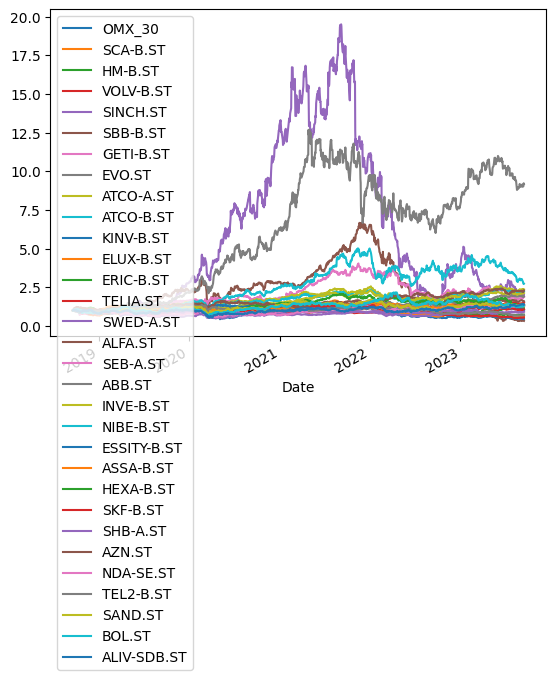

In [2]:
import yfinance
import datetime
import matplotlib.pyplot as plt

# Get today's date
date = datetime.datetime.today().strftime('%Y-%m-%d')
# Start date is 5 years ago
start_date = datetime.datetime.today() - datetime.timedelta(days=5*365)

# Get the data for the stock Apple by specifying the stock ticker, start date, and end date
data = yfinance.download('^OMX', start_date, date)

# Select only the Close column and rename it simply as "OMX_30"
data = data[['Close']]
data = data.rename(columns={'Close':'OMX_30'})

# Add a column fpr each ticker
for ticker in tickers_OMX:
    data[ticker] = yfinance.download(ticker,start_date,date)['Close']

# Divide each column by the price at start date
data = data/data.iloc[0]

# Plot the prices and show a red bar in red when it is NaN
data.plot()
plt.show()

## Plot the correlation between the index and the stocks from the index

Look at the strongest and lowest correlation and plots the graphs side by side

/home/vscode/.local/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


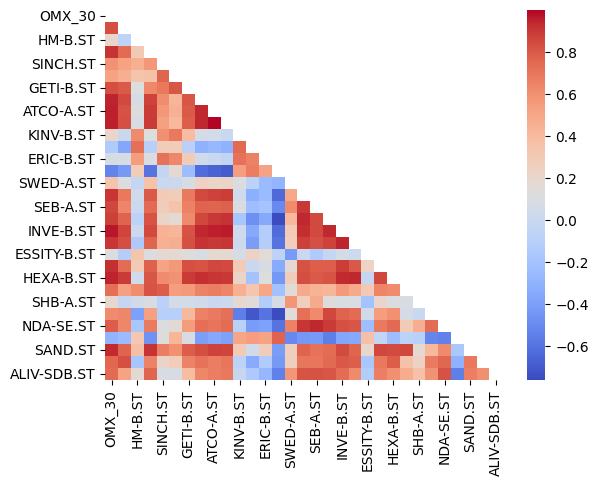

In [3]:
import seaborn as sns
import numpy as np
corr = data.corr()
# Only keep the upper right triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Check the stocks the most correlated with the index over the last 5 years

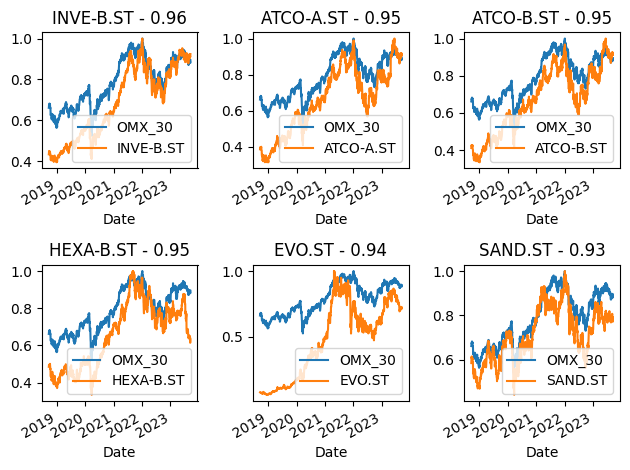

In [4]:
corr_omx = corr['OMX_30'].sort_values(ascending=False)

for k, (index, value) in enumerate(corr_omx.items()):
    plt.subplot(2,3,k+1)
    (data['OMX_30']/(data['OMX_30'].max())).plot()
    (data[index]/(data[index].max())).plot()
    plt.legend()
    plt.title(f'{index} - {value:.2f}')
    if k == 5:
        break
plt.tight_layout()
plt.show()

Check the stocks that are the less correlated

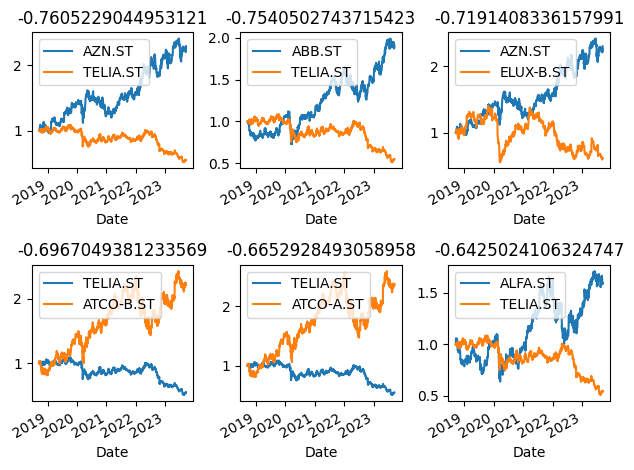

In [5]:
import numpy as np
indices = np.argsort(corr, axis=None)
indices = np.unravel_index(indices, corr.shape)
indices = list(zip(*indices))

values = corr.values
for k, index in enumerate(indices[:6]):
    plt.subplot(2,3, k+1)
    x, y = corr.index[index[0]], corr.columns[index[1]]
    data[x].plot()
    data[y].plot()
    plt.legend()
    plt.title(values[index])
plt.tight_layout()
plt.show()


## Compute the beta of the different stocks

In [6]:
# Importing libraries and packages
import statsmodels.api as sm
from statsmodels import regression
import pandas as pd

# Resample the data to monthly frequency
data_monthly = data.resample('m').last()

# Convert to percentage returns
data_monthly = data_monthly.pct_change()

# Remove the first row which is NaN
data_monthly.dropna(inplace=True)

# Get the column OMX_30 and remove it from the dataframe
omx = data_monthly['OMX_30']
data_monthly.drop(columns=['OMX_30'], inplace=True)

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()

    # We are removing the constant
    x = x[:, 1]
    return model.params[0], model.params[1]

betas = []
for ticker in data_monthly.columns:
    # Get the column for the ticker
    col = data_monthly[ticker]
    alpha, beta = linreg(omx.values, col.values)
    betas.append(beta)

# Create a dataframe with the tickers and betas
df_betas = pd.DataFrame()
df_betas['Ticker'] = data_monthly.columns
df_betas['Beta'] = betas

# Set the index to be the tickers
df_betas.set_index('Ticker', inplace=True)

df_betas.head()  


,Beta
Ticker,
SCA-B.ST,0.729674
HM-B.ST,1.414052
VOLV-B.ST,1.188417
SINCH.ST,1.375065
SBB-B.ST,1.391251
